# Baseline methods

In [47]:
import src
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import partial

import numpy as np
from sklearn.decomposition import PCA

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator
from sklearn.feature_selection.base import SelectorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


K.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=1, 
                                               inter_op_parallelism_threads=1, 
                                               allow_soft_placement=True, 
                                               device_count = {'CPU': 10})))

In [2]:
tissues = {
    'breast': ['BRCA'],
    'lung': ["LUSC", "LUAD"],
    'kidney': ["KIRC", "KICH", "KIRP"]
}

In [3]:
cohorts = {}

idx_to_gene, _ = src.data.load_gene_indices()
for tissue, datasets in tissues.items():
    print(tissue)
    X_tissue, idx_to_sample_tissue, y_tissue = np.empty((0, idx_to_gene.shape[0])), [], np.empty(0, dtype=int)
    for d in datasets:
        X_d, idx_to_sample_d, _, y_d, classes = src.data.get_normal_vs_tumor_task(d)
        X_tissue = np.vstack([X_tissue, X_d])
        idx_to_sample_tissue = np.append(idx_to_sample_tissue, idx_to_sample_d.values)
        y_tissue = np.append(y_tissue, y_d)
    idx_to_sample_tissue = pd.Series(data=idx_to_sample_tissue, index=np.arange(X_tissue.shape[0], dtype=int))
    cohorts[tissue] = (X_tissue, idx_to_sample_tissue, idx_to_gene, y_tissue, classes)

breast
lung
kidney


## PCA analysis

In [4]:
color_mapping = {
    'Solid Tissue Normal': '#191970',
    'Primary Tumor': "#FF3232"
}

def plot_PCA(X, y, classes, color_mapping):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    for cy in np.unique(y):
        sns.regplot(X_pca[y == cy, 0], X_pca[y == cy, 1], color=color_mapping[classes[cy]], fit_reg=False, label=classes[cy])
    plt.legend()
    plt.xlabel("1st component ({:.2f}%)".format(pca.explained_variance_ratio_[0] * 100))
    plt.ylabel("2nd component ({:.2f}%)".format(pca.explained_variance_ratio_[1] * 100))

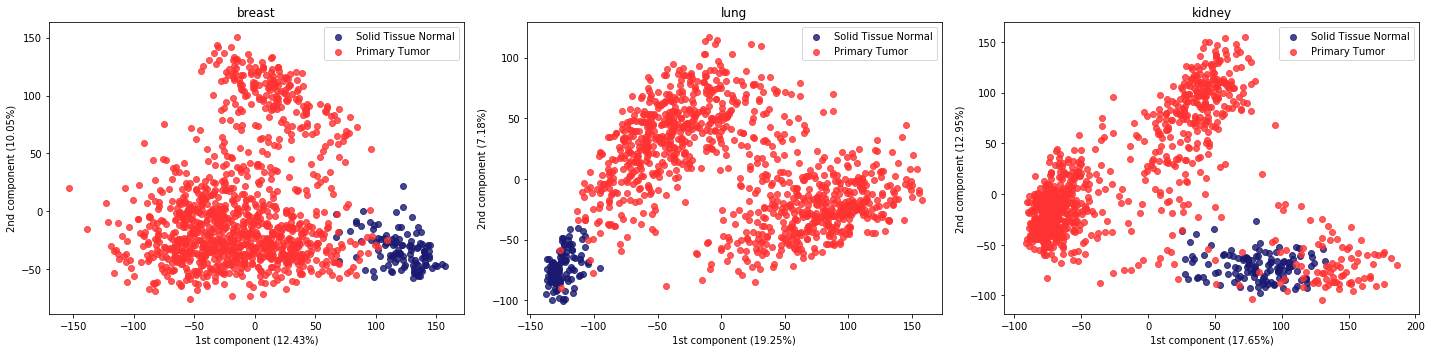

In [5]:
plt.figure(figsize=(20, 5))
i = 1
for cohort in cohorts.keys():
    X_cohort, _, _, y_cohort, classes_cohort = cohorts[cohort]
    plt.subplot(1, len(cohorts), i)
    plot_PCA(X_cohort, y_cohort, classes_cohort, color_mapping)
    plt.title(cohort)
    i += 1
plt.tight_layout()
plt.show()   

## Baseline classifiers

### Top Variant Feature Selection

In [6]:
class TopVariantSelector(BaseEstimator, SelectorMixin):
    """ A very simple feature selector which uses the top variant features """
    def __init__(self, top_k):
        self.top_k = top_k
    
    def fit(self, X, y=None):
        stds = X.std(0) # 1 x n.genes
        selected_genes = np.argsort(stds)[::-1][:self.top_k]
        self.selected_features_ = selected_genes
        self.mask_ = np.in1d(np.arange(X.shape[1]), selected_genes)
        return self
        
    def _get_support_mask(self):
        check_is_fitted(self, 'selected_features_')
        check_is_fitted(self, 'mask_')
        return self.mask_

## Metrics

In [39]:
def get_confusion_matrix_old(y_true, y_pred, names):
    return pd.DataFrame(data=confusion_matrix(y_true=y_true, y_pred=y_pred), 
                        index=pd.Series(names, name='Observed'), columns=pd.Series(names, name='Predicted'))

def get_confusion_matrix(y_true, y_pred):
    normal_normal, normal_tumor, tumor_normal, tumor_tumor = confusion_matrix(y_true=y_true, y_pred=y_pred).flatten()
    cm = pd.DataFrame(data=[[normal_normal, normal_tumor, tumor_normal, tumor_tumor]], 
                      columns=['normal_normal', 'normal_tumor', 'tumor_normal', 'tumor_tumor'])
    cm.index.name = 'true_observed'
    return cm

def sum_confusion_matrices(results_cohort):
    r_cm = None
    for _, cm in results_cohort.items():
        if r_cm is None:
            r_cm = cm
        else:
            r_cm += cm
    return cm

In [53]:
def tumor_alone_model(input_size):
    """ A super-simple NN for the single tumor classification
    """
    model = Sequential()
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['val_loss'])
    return model

In [55]:
seed = 42
n_repeated = 5
n_folds = 5
top_variant = 5000

preprocessing = [('variance_selector', TopVariantSelector(top_k=top_variant)), ('minmax_scaler', MinMaxScaler())]

pipelines = {
    'SVM': Pipeline(preprocessing + [('classifier', LinearSVC(max_iter=10000, random_state=seed))]),
    'KNN': Pipeline(preprocessing + [('classifier', KNeighborsClassifier(n_neighbors=5))]),
    'RF': Pipeline(preprocessing + [('classifier', RandomForestClassifier(n_estimators=10, random_state=seed))]),
    'FFNN': Pipeline(preprocessing + [('classifier', KerasClassifier(partial(tumor_alone_model, input_size=top_variant), 
                                                                     epochs=20, batch_size=10, verbose=0, validation_split=0.3,
                                                                     callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, 
                                                                                                patience=0, verbose=0,
                                                                                                restore_best_weights=True)]))])
}

def repeated_cross_validation(pipelines, X_tissue, y_tissue, seed=42, n_repeated=5, n_folds=5):
    results = {}

    for t in range(n_repeated):
        print("Repetition {}".format(t + 1))
        skf = StratifiedKFold(n_splits=n_folds, random_state=seed + t, shuffle=True)
        i = 0
        for train_idx, test_idx in skf.split(X_tissue, y_tissue):
            X_train, y_train = X_tissue[train_idx, :], y_tissue[train_idx]
            X_test, y_test = X_tissue[test_idx, :], y_tissue[test_idx]
            print("\tSplit {}\tTrain ({}, {})\tTest ({}, {})".format(i, y_train[y_train == 0].shape[0], 
                                                                     y_train[y_train == 1].shape[0],
                                                                     y_test[y_test == 0].shape[0], 
                                                                     y_test[y_test == 1].shape[0]))
            for pname, p in pipelines.items():
                print("\t\tPipeline {}".format(pname))
                p.fit(X_train, y_train)
                y_pred = p.predict(X_test)
                cm_tip = get_confusion_matrix(y_true=y_test, y_pred=y_pred)
                cm_tip['repetition'] = t
                cm_tip['fold'] = i

                if pname in results.keys():
                    results[pname] = pd.concat([results[pname], cm_tip], axis=0, ignore_index=True)
                    results[pname].index.name = 'true_predicted'
                else:
                    results[pname] = cm_tip
            i += 1
    return results

In [56]:
for tissue in cohorts.keys():
    X_tissue, _, _, y_tissue, classes = cohorts[tissue]
    os.makedirs(src.reports_dir / "confusion_matrices" / tissue, exist_ok=True)
    print("Tissue {}".format(tissue))
    results = repeated_cross_validation(pipelines, X_tissue, y_tissue, seed=seed, n_repeated=n_repeated, n_folds=n_folds)
    for pname, presults in results.items():
        presults.to_csv(src.reports_dir / "confusion_matrices" / tissue / "{}.tsv".format(pname), 
                        sep="\t", index=True, header=True, index_label="true_predicted")

Tissue breast
Repetition 1
	Split 0	Train (91, 877)	Test (23, 220)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
	Split 1	Train (91, 877)	Test (23, 220)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
	Split 2	Train (91, 878)	Test (23, 219)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
	Split 3	Train (91, 878)	Test (23, 219)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
	Split 4	Train (92, 878)	Test (22, 219)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
Repetition 2
	Split 0	Train (91, 877)	Test (23, 220)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
	Split 1	Train (91, 877)	Test (23, 220)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
	Split 2	Train (91, 878)	Test (23, 219)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
	Split 3	Train (91, 878)	Test (23, 219)
		Pipeline SVM
		Pipeline KNN
		Pipeline RF
		Pipeline FFNN
	Split 4	Train (92, 878)	Test (22, 219)
		Pipeline SVM
		Pip